In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [11]:
# Load data
path = "../data/func_invc_present"
data = {}
for root, dirs, files in os.walk(path):
    for filename in files:
        if filename.endswith(".csv"):
            path_parts = os.path.normpath(root).split(os.sep)
            if path_parts[-2] not in data:
                data[path_parts[-2]] = {}
            data[path_parts[-2]][os.path.join(root, filename)] = []


In [12]:
# Define malicious patterns and load runs
malicious_patterns = ['kmeans-clustering-fileop-type', 'kmeans-clustering-code-type', 
                      'kmeans-clustering-command-type', 'kmeans-clustering-info-type']

all_runs = []
all_labels = []

for category, files_dict in data.items():
    for filepath in files_dict.keys():
        df = pd.read_csv(filepath)
        label = 1 if any(p in filepath for p in malicious_patterns) else 0
        
        for run_id, run_df in df.groupby('run'):
            all_runs.append(run_df['syscall'].tolist())
            all_labels.append(label)

max_seq_length = max(len(run) for run in all_runs)
print(f"Total runs: {len(all_runs)}, Max length: {max_seq_length}")
print(f"Benign: {sum(1 for l in all_labels if l == 0)}, Malicious: {sum(1 for l in all_labels if l == 1)}")


Total runs: 774, Max length: 2831
Benign: 480, Malicious: 294


In [13]:
# Build vocabulary
all_syscalls = [syscall for run in all_runs for syscall in run]
vocab = ['<PAD>'] + sorted(list(set(all_syscalls)))
syscall_to_idx = {s: i for i, s in enumerate(vocab)}
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 81


In [14]:
# Encode and pad sequences
def encode_pad(syscalls, max_len):
    encoded = [syscall_to_idx[s] for s in syscalls]
    return encoded[:max_len] + [0] * max(0, max_len - len(encoded))

X = np.array([encode_pad(run, max_seq_length) for run in all_runs])
y = np.array(all_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (619, 2831), Test: (155, 2831)


In [15]:
# Create DataLoaders
train_dataset = TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
# Define Transformer Model
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_heads=2, num_layers=1, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=64, 
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 2)
        
    def forward(self, x):
        mask = (x == 0)
        x = self.embedding(x) + self.pos_encoding[:, :x.size(1), :]
        x = self.transformer(x, src_key_padding_mask=mask)
        
        # Global average pooling
        mask_expanded = (~mask).unsqueeze(-1).float()
        x = (x * mask_expanded).sum(1) / (mask_expanded.sum(1) + 1e-9)
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(len(vocab), max_len=max_seq_length).to(device)
print(f"Device: {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


Device: cuda
Parameters: 101,794


In [17]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(10):
    # Train
    model.train()
    train_loss, correct, total = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for X_batch, y_batch in train_loader_tqdm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)
        train_loader_tqdm.set_postfix(loss=loss.item())
    
    # Evaluate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1} [Eval]", leave=False)
        for X_batch, y_batch in test_loader_tqdm:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            batch_loss = criterion(outputs, y_batch).item()
            val_loss += batch_loss
            val_correct += (outputs.argmax(1) == y_batch).sum().item()
            val_total += y_batch.size(0)
            test_loader_tqdm.set_postfix(loss=batch_loss)
    
    train_acc = correct / total
    val_acc = val_correct / val_total
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


Epoch 1 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5690, Train Acc=0.6866, Val Acc=0.8516


Epoch 2 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.3834, Train Acc=0.8384, Val Acc=0.8968


Epoch 3 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.2628, Train Acc=0.8691, Val Acc=0.8968


Epoch 4 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.1701, Train Acc=0.9192, Val Acc=0.9742


Epoch 5 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.0870, Train Acc=0.9725, Val Acc=0.9742


Epoch 6 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.0687, Train Acc=0.9758, Val Acc=0.9871


Epoch 7 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.0801, Train Acc=0.9774, Val Acc=0.9742


Epoch 8 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0576, Train Acc=0.9855, Val Acc=0.9935


Epoch 9 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 [Eval]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0306, Train Acc=0.9935, Val Acc=1.0000


Epoch 10 [Train]:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
history_df = pd.DataFrame(history)
history_df.to_csv('results/training_history.csv', index=False)

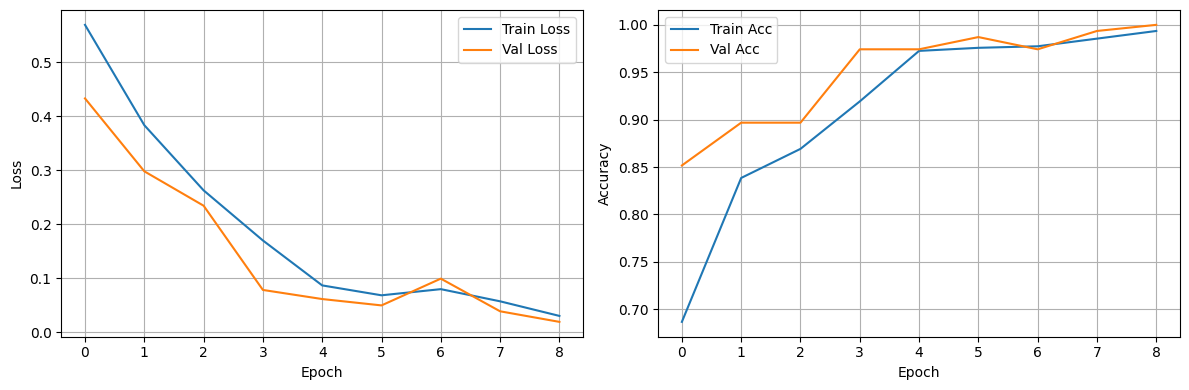

In [18]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



Test Results:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


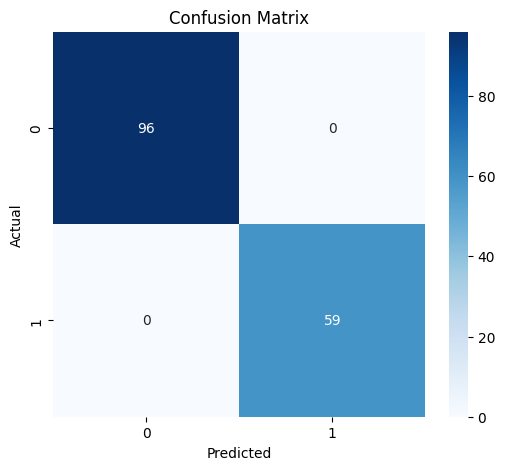

In [19]:
# Final evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y_batch.numpy())

acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

print(f"\nTest Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save model
torch.save({
    'model_state': model.state_dict(),
    'vocab': vocab,
    'syscall_to_idx': syscall_to_idx,
    'max_seq_length': max_seq_length
}, 'results/transformer_model.pth')
print("Model saved!")


Model saved!
